In [1]:
import pandas as pd
import numpy as np

import time, datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [2]:
train = pd.read_csv('BPI_Challenge_2012-training.csv')
test = pd.read_csv('BPI_Challenge_2012-test.csv')

### **Functions concerning time**

In [3]:
def month(x):
    """Convert object to the month of year

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.month

def day(x):
    """Convert object to the day of year

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.day

def week(x):
    """Convert object to the week of year

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.week

def day_week(x):
    """Convert object to the day of week

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.weekday()

def time_of_day(x):
    """Convert object to the hour of the day

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.hour

### **Function 'time_conversion**

In [4]:
def time_conversion(dataframe):
    """Transform 'event time:timestamp' and 'case REG_DATE' from str to DateTime in a given Dataframe
        Additionally, this function creates timestamps for the start and finish of a task in a seperate column. 
        The difference between these timestaps is the time to complete a task, which is also added to the dataframe.

        Commented out lines are still for discussion
        
    Args:
        dataframe (pd.DataFrame): A pd.DataFrame in the format from the BPI_challenge 2012

    Returns:
        dataframe_output: A pd.DataFrame with all the strings reformatted to DateTime in the 'event time:timestamp' and 'case REG_DATE' columns
    """
    
#     dataframe.drop(columns = ['eventID '], inplace=True) # Drop eventID
    dataframe.reset_index(inplace=True)
    
    #Transform 'event time:timestamp' and 'case REG_DATE' from str to DateTime  
    dataframe['case REG_DATE'] =  pd.to_datetime(dataframe['case REG_DATE'])
    dataframe['event time:timestamp'] =  pd.to_datetime(dataframe['event time:timestamp'])
    
    #Creates timestamps for the start and finish of a task in a seperate column + the time to complete the task.
    dataframe['timestamp_start'] = dataframe['case REG_DATE'].values.astype(np.int64) // 10 ** 9
    dataframe['timestamp_finish'] = dataframe['event time:timestamp'].values.astype(np.int64) // 10 ** 9 
#     dataframe['time_to_complete']= (dataframe["event time:timestamp"] - dataframe["case REG_DATE"])/10**6


    # Convert the timestamps of the event time to day of week, specific day and time of that day.
    
    dataframe["day_week"] = dataframe["event time:timestamp"].apply(day_week)
    # dataframe["week"] = dataframe["event time:timestamp"].apply(week)
#     dataframe["day_month"] = dataframe["event time:timestamp"].apply(day)
    # dataframe["month"] = dataframe["event time:timestamp"].apply(month)
    dataframe['time_of_day'] = dataframe['event time:timestamp'].apply(time_of_day)
    
    return dataframe

### ** Function 'encoding'**

In [5]:
def encoding(dataframe):
    """Encoding 

    What kind of encoding is this exactly?
    
    Args:
        dataframe (pd.DataFrame): A pd.DataFrame in the format from the BPI_challenge 2012

    Returns:
        dataframe: A pd.DataFrame with cases and events sorted wrt time, each event has a position within its case
    """
    # sort cases wrt time, for each case sort events 
    dataframe.sort_values(['timestamp_start',"timestamp_finish"], axis=0, ascending=True, inplace=True, ignore_index=True)
    
    # assign the position in the sequence to each event
    dataframe['position'] = None
    dataframe['position'] = dataframe.groupby('case concept:name').cumcount() + 1
    
    
    # create columns with previous and future (times of) events
    
    dataframe['event time:timestamp'] =  pd.to_datetime(dataframe['event time:timestamp'])
    dataframe['event time:timestamp'] =  pd.to_datetime(dataframe['event time:timestamp'])
   
    dataframe["prev_event"] = dataframe.groupby("case concept:name")["event concept:name"].shift(1)
    dataframe["2prev_event"] = dataframe.groupby("case concept:name")["event concept:name"].shift(2)
    dataframe["next_event"] = dataframe.groupby("case concept:name")["event concept:name"].shift(-1)

    dataframe["prev_time"] = dataframe.groupby("case concept:name")["event time:timestamp"].shift(1)
    dataframe["next_time"] = dataframe.groupby("case concept:name")["event time:timestamp"].shift(-1)
    dataframe['prev_time'] =  pd.to_datetime(dataframe['prev_time'])
    dataframe['next_time'] =  pd.to_datetime(dataframe['next_time'])


    dataframe["next_event"].fillna("LAST EVENT", inplace=True)
    dataframe["prev_event"].fillna("FIRST EVENT", inplace=True)
    dataframe["2prev_event"].fillna("FIRST EVENT", inplace=True)
    
    
    
#     these values should be empty and filling them equals creating wrong data, but otherwise models dont work :( 
    dataframe["next_time"].fillna(method='ffill', inplace=True)
    dataframe["prev_time"].fillna(method='bfill', inplace=True)
    dataframe["next_time"].fillna(method='ffill', inplace=True)
    dataframe["prev_time"].fillna(method='bfill', inplace=True)

    return dataframe

### **Function: 'preprocessing'**

In [6]:
def preprocessing(dataframe):
    """Does all the processing needed for the naive estimator

    Args:
        dataframe (pd.DataFrame): A pd.DataFrame in the format from the BPI_challenge 2012
    """
    pp_df = encoding(time_conversion(dataframe))
    
    
    return pp_df

## **Preprocessing and splitting**

In [7]:
# merge the data sets and preprocess
# train = pd.concat([train, test], axis="rows", ignore_index=True)


# train = preprocessing(train)
# test = preprocessing(test)

train['case REG_DATE'] =  pd.to_datetime(train['case REG_DATE'])
train['event time:timestamp'] =  pd.to_datetime(train['event time:timestamp'])

test['case REG_DATE'] =  pd.to_datetime(test['case REG_DATE'])    
test['event time:timestamp'] =  pd.to_datetime(test['event time:timestamp'])

In [8]:
# train.drop(['index'],axis='columns',inplace=True)

In [9]:
# a check for duplicate events, gives error if none repeat
# pd.concat(g for _, g in train.groupby("eventID ") if len(g) > 1).tail(50)

In [10]:
# train = train.iloc[:239787]
# test = train.iloc[239787:]

### **Export dataframe to .CSV**

In [19]:
train.to_csv('preprocessed_train.csv')
test.to_csv('preprocessed_test.csv')

In [12]:
# Find the timestamp of the first event in the test set
first_test_event_timestamp = test['event time:timestamp'].min()

# Filter out cases that end after the first test event starts or start before the first train event
train_data_filtered = train.groupby('case concept:name').filter(lambda g: g['event time:timestamp'].min() < first_test_event_timestamp and g['event time:timestamp'].max() < first_test_event_timestamp)



In [13]:
train.shape

(239786, 8)

In [14]:
train_data_filtered.shape

(122123, 8)

In [15]:
first_test_event_timestamp

Timestamp('2012-01-02 11:00:35.791000')

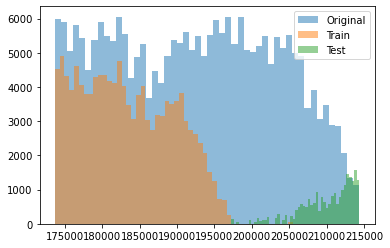

In [16]:
import matplotlib.pyplot as plt

# Plot histogram of the feature in the original dataset
plt.hist(train['case concept:name'], bins=50, alpha=0.5, label='Original')

# Plot histogram of the feature in the training set
plt.hist(train_data_filtered['case concept:name'], bins=50, alpha=0.5, label='Train')

# Plot histogram of the feature in the testing set
plt.hist(test['case concept:name'], bins=50, alpha=0.5, label='Test')

plt.legend(loc='upper right')
plt.show()


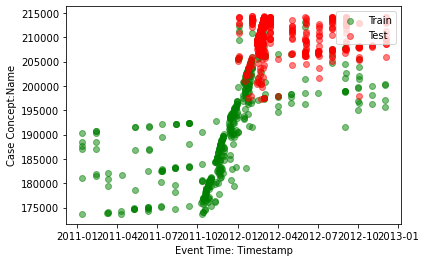

In [17]:
# Plot scatter plot of event timestamp vs case concept:name for the training data
plt.scatter(train['event time:timestamp'].sample(frac=0.002, replace=True, random_state=1), train['case concept:name'].sample(frac=0.002, replace=True, random_state=1), alpha=0.5, label='Train', color='green')

# Plot scatter plot of event timestamp vs case concept:name for the testing data
plt.scatter(test['event time:timestamp'].sample(frac=0.02, replace=True, random_state=1), test['case concept:name'].sample(frac=0.02, replace=True, random_state=1), alpha=0.5, label='Test', color='red')

plt.xlabel('Event Time: Timestamp')
plt.ylabel('Case Concept:Name')
plt.legend(loc='upper right')
plt.show()

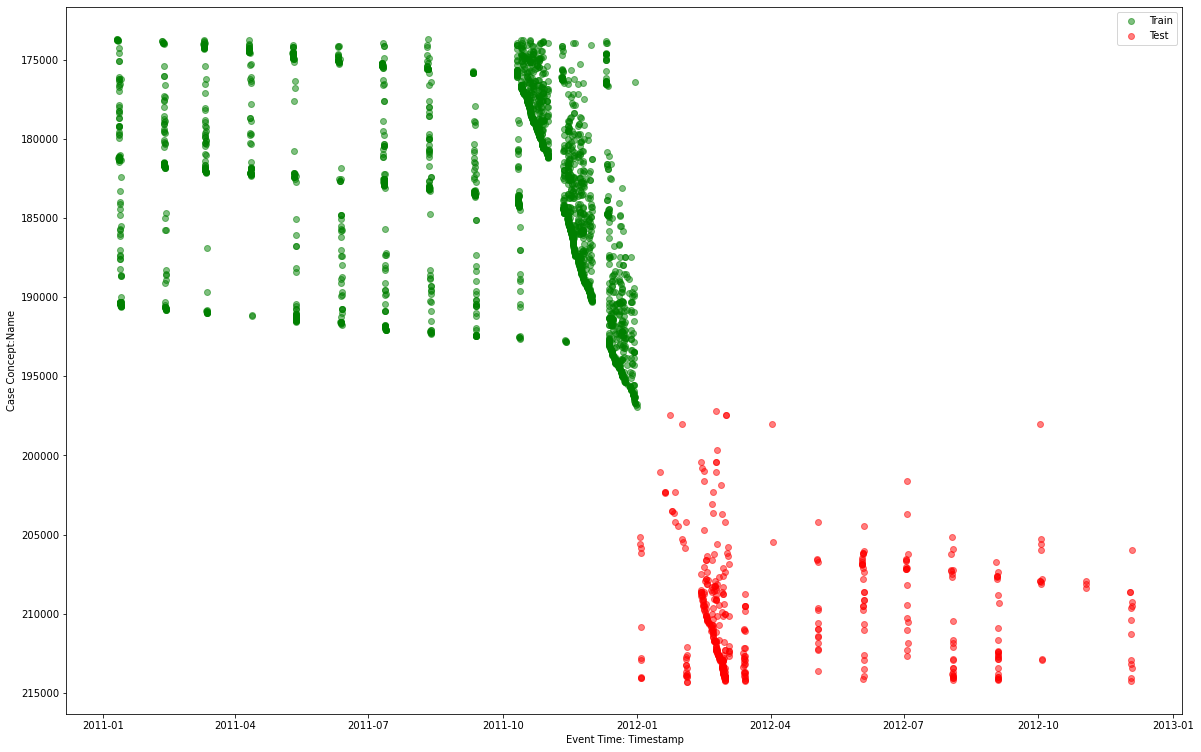

In [25]:
# Plot scatter plot of event timestamp vs case concept:name for the training data

plt.scatter(train_data_filtered['event time:timestamp'].sample(frac=0.02, replace=True, random_state=1), train_data_filtered['case concept:name'].sample(frac=0.02, replace=True, random_state=1), alpha=0.5, label='Train', color='green')

# Plot scatter plot of event timestamp vs case concept:name for the testing data
plt.scatter(test['event time:timestamp'].sample(frac=0.02, replace=True, random_state=1), test['case concept:name'].sample(frac=0.02, replace=True, random_state=1), alpha=0.5, label='Test', color='red')

plt.rcParams["figure.figsize"] = (20,20)
plt.xlabel('Event Time: Timestamp')
plt.ylabel('Case Concept:Name')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()
plt.show()